# Forecasting

In this workshop, you will forecast the charging profile of a real EV based on historic data of consumption. 
The dataset you will use corresponds to the charging times of many different households during several years. 


In [1]:
import warnings
warnings.filterwarnings("ignore")

# Donwload the data

In [2]:
!wget -O Substation.csv 'https://unice-my.sharepoint.com/:x:/g/personal/benoit_couraud_unice_fr/EYtTpfNB8IVPi-D0EtxtM68B_e4nDKbEADCQ7cX1M7i1KQ?download=1'

!pip install pandas
import pandas as pd
tab = pd.read_csv('Substation.csv', sep=',')
tab.head



--2022-08-19 00:23:46--  https://unice-my.sharepoint.com/:x:/g/personal/benoit_couraud_unice_fr/EYtTpfNB8IVPi-D0EtxtM68B_e4nDKbEADCQ7cX1M7i1KQ?download=1
Resolving unice-my.sharepoint.com (unice-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to unice-my.sharepoint.com (unice-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/benoit_couraud_unice_fr/Documents/Lectures/Artificial%20Intelligence/Object_Detection/3_Transfer_Learning_Custom_Objects/Useful_Files/Substation.csv?ga=1 [following]
--2022-08-19 00:23:47--  https://unice-my.sharepoint.com/personal/benoit_couraud_unice_fr/Documents/Lectures/Artificial%20Intelligence/Object_Detection/3_Transfer_Learning_Custom_Objects/Useful_Files/Substation.csv?ga=1
Reusing existing connection to unice-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 1767675 (1.7M) [application/octet-stream]
Saving to: ‘Substation.csv’

Substation.csv    

<bound method NDFrame.head of                   time     value
0       11/1/2019 0:00  3.275606
1       11/1/2019 0:15  3.361022
2       11/1/2019 0:30  3.390457
3       11/1/2019 0:45  3.307523
4       11/1/2019 1:00  3.229266
...                ...       ...
67483  10/3/2021 22:45  2.492596
67484  10/3/2021 23:00  2.380433
67485  10/3/2021 23:15  2.228033
67486  10/3/2021 23:30  2.373711
67487  10/3/2021 23:45  2.487879

[67488 rows x 2 columns]>

# Data Processing/Cleaning

Before implementing a model, we first need to clean the data and prepare it for the training phase.

# Let's select columns of interest

In [3]:
mycolumns = ['time','value']
df=tab[mycolumns]


A = df
# add the day of week information
A['time'] = pd.to_datetime(A['time'])
A['day_of_week'] = A['time'].dt.dayofweek

# A = df.loc[df['ChargerID'] == End_user_ID]
# # add the day of week information
# A['TimeStamp'] = pd.to_datetime(A['TimeStamp'])
# A['day_of_week'] = A['TimeStamp'].dt.dayofweek
# # normalise the power: we only want to know if the end-user charged or not. 
# A.loc[A['Power_W'] > Min_Power, 'Power_W'] = 1

In [4]:
A

,time,value,day_of_week
0,2019-11-01 00:00:00,3.275606,4
1,2019-11-01 00:15:00,3.361022,4
2,2019-11-01 00:30:00,3.390457,4
3,2019-11-01 00:45:00,3.307523,4
4,2019-11-01 01:00:00,3.229266,4
...,...,...,...
67483,2021-10-03 22:45:00,2.492596,6
67484,2021-10-03 23:00:00,2.380433,6
67485,2021-10-03 23:15:00,2.228033,6
67486,2021-10-03 23:30:00,2.373711,6


In [5]:
import itertools


year_list = []
month_list = []
day_list = []
hour_list = []
minute_list = []
min_timeinterval = 15

for combination in itertools.product([2022],[1],[1],list(range(0,24)), [0,15,30,45]): # we define a dummy day 2022/01/01 but we are only interested in the time from 0h to 24h
        #print(combination) 
        year_list.append( combination[0] )
        month_list.append( combination[1] )
        day_list.append( combination[2] )
        hour_list.append( combination[3] )
        minute_list.append( combination[4] )


data = {'year':year_list,
                'month':month_list,
                'day':day_list,
                'hour':hour_list,
                'minute':minute_list,
                }

fullday_df = pd.DataFrame(data=data)

fullday_df['time'] = pd.to_datetime( fullday_df[['year', 'month', 'day', 'hour', 'minute']]) #Convert time format to "yyyy-mm-dd hh:mm:ss"
fullday_df = fullday_df.drop(columns=['year', 'month', 'day', 'hour', 'minute']) #Keep only time items
print(fullday_df)

                  time
0  2022-01-01 00:00:00
1  2022-01-01 00:15:00
2  2022-01-01 00:30:00
3  2022-01-01 00:45:00
4  2022-01-01 01:00:00
..                 ...
91 2022-01-01 22:45:00
92 2022-01-01 23:00:00
93 2022-01-01 23:15:00
94 2022-01-01 23:30:00
95 2022-01-01 23:45:00

[96 rows x 1 columns]


# Create Training dataset

In this subsection, we will create the output for one day: we now want to create the targets and inputs for our training.
Inputs will be:
1. the type of day (= 0 for monday, ... 6 for sunday)
2. the consumption on the previous day
3. the consumption on the day before the previous day
4. the consumption 3 days before

Outputs will be:
a vector of 96 elements, corresponding to all the quarters in a day. these elements will thus correspond to a timeslot in the day. the first element corresponds to 0:00:00, the second one to 00:00:15  and so on...
These elements will be equal to 1 if the EV is charging at the corresponding time, 0 otherwise.

In [6]:
# first let's convert the data into numpy arrays
from datetime import datetime
!pip install numpy
import numpy as np
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
Power = A['value'].to_numpy()
#on recupere le temps dans timearray
timearray = []
timearray = A['time'].to_numpy()
timearray_fullday = []
timearray_fullday = fullday_df['time'].to_numpy()
Day_type = A['day_of_week'].to_numpy()
print(A['time'])
print(timearray)
print(timearray_fullday)

0       2019-11-01 00:00:00
1       2019-11-01 00:15:00
2       2019-11-01 00:30:00
3       2019-11-01 00:45:00
4       2019-11-01 01:00:00
                ...        
67483   2021-10-03 22:45:00
67484   2021-10-03 23:00:00
67485   2021-10-03 23:15:00
67486   2021-10-03 23:30:00
67487   2021-10-03 23:45:00
Name: time, Length: 67488, dtype: datetime64[ns]
['2019-11-01T00:00:00.000000000' '2019-11-01T00:15:00.000000000'
 '2019-11-01T00:30:00.000000000' ... '2021-10-03T23:15:00.000000000'
 '2021-10-03T23:30:00.000000000' '2021-10-03T23:45:00.000000000']
['2022-01-01T00:00:00.000000000' '2022-01-01T00:15:00.000000000'
 '2022-01-01T00:30:00.000000000' '2022-01-01T00:45:00.000000000'
 '2022-01-01T01:00:00.000000000' '2022-01-01T01:15:00.000000000'
 '2022-01-01T01:30:00.000000000' '2022-01-01T01:45:00.000000000'
 '2022-01-01T02:00:00.000000000' '2022-01-01T02:15:00.000000000'
 '2022-01-01T02:30:00.000000000' '2022-01-01T02:45:00.000000000'
 '2022-01-01T03:00:00.000000000' '2022-01-01T03:15:00

In [8]:
from datetime import timedelta
# conversion des dates, et on enleve les lignes qui n'etaient pas bonnes (time not in a date format, or just some space instaead of time)
# We create the training (input and target) dataset:

Allday_output = np.empty((96,0),int)
input = np.empty((4,0))
# min_timeinterval = 15
# we create a function that generates a vector with 96 elements, with 1 when the car was charging, 0 when it was not.
# Power: "value" for the samples[67200:67296](final).
# data_time: "time" for the samples[67200:67296](final).
# time_fullday: "time" for the dummy day 2022/01/01.
def generate_daily_profile(power, data_time, time_fullday):
    out_profile = []
    index = 0
    for element in time_fullday:
        element = element - np.timedelta64(round((element - data_time[0])/np.timedelta64(1, 'D')),'D') 
        #we change the year month and day of the reference time array for full day
        # 计算element - data_time[0]，单位"ns"；
        # (element - data_time[0])/np.timedelta64(1, 'D')，单位"day"； round为取整,48时为90天，48时为91天
        # np.timedelta64为强制类型转换，再定义单位为"day"
        if (index < data_time.size) and (abs(data_time[index] - element)/np.timedelta64(1, 's') < min_timeinterval/2):  #if the time we have here is in the input data_time array, this means we are charging
            out_profile.append(power[index])
            index = index+1
        else:
            out_profile.append(0)

    return out_profile, index

#first, we must identify the number of days
nb_day = 0
previous_element = timearray[0]
for element in timearray:
    if element.astype('M8[D]') != previous_element.astype('M8[D]'): # 'M8[D]': 2019-11-01
        if nb_day>=29:
            temp=0 # ???
        nb_day = nb_day +1
    previous_element = element

previous_element = timearray[0]
idx_timearray = 0
previous_idx_timearray = 0
count = 0
consumption_d3 = 0  # consumption of the day -3
consumption_d2 = 0  # consumption of the day -2
consumption_d1 = 0  # consumption of the day -1
consumption_d4 = 0
consumption_d5 = 0
consumption_d6 = 0
consumption_d7 = 0
consumption_d8 = 0
consumption_d9 = 0
consumption_d10 = 0
consumption_d11 = 0
consumption_d12 = 0
consumption_d13 = 0
consumption_d14 = 0

for day in range(nb_day):
    # print(day)
    if day >=20:
        temp = 0
    for idx in range(97):#  element in timearray: # we will go through the end user data
        # print(idx)

        if timearray[idx+idx_timearray].astype('M8[D]') != previous_element.astype('M8[D]'):
            # dailyprofile_power,current_index = generate_daily_profile(Power[idx_timearray:idx_timearray+idx],timearray[idx_timearray:idx_timearray+idx], timearray_fullday )
            #********************************************************************************
            data_time = timearray[idx_timearray:idx_timearray+idx]
            power = Power[idx_timearray:idx_timearray+idx]
            time_fullday = timearray_fullday 
            out_profile = []
            index = 0
            for element in time_fullday:
                
                element = element - np.timedelta64(round((element - data_time[min(index,data_time.size-1)])/np.timedelta64(1, 'D')),'D') #we change the year month and day of the reference time array for full day
                if (index < data_time.size) and (abs(data_time[index] - element)/np.timedelta64(1, 's') < min_timeinterval/2):  #if the time we have here is in the input data_time array, this means we are charging
                    out_profile.append(power[index])
                    index = index+1
                else:
                    out_profile.append(0)

            dailyprofile_power = out_profile
            current_index = index
            # nb_day = 0. idx = 0, does not enter the loop
            # nb_day = 0. idx = 1， power = Power[0:96], out_profile[0:idx] = power[0:idx], out_profile[idx:96] = 0, index = idx; "if (index < data_time.size)""
            # ......
            # nb_day = 701. idx = 96, power = Power[67200:67296], out_profile[0:96] = power[0:96], index = 96


            #****************************************************************************
            c = np.datetime_as_string(timearray_fullday, timezone='UTC')
            # df_c = pd.DataFrame(c, columns = ['time'])
            # df_c['power'] = dailyprofile_power
            # df_c.to_csv('daily_profile.csv')

            input = np.c_[input, [Day_type[idx_timearray],consumption_d1,consumption_d2,consumption_d3] ]
            consumption_d3 = consumption_d2
            consumption_d2 = consumption_d1
            consumption_d1 = sum(dailyprofile_power)

            # input = np.c_[input, [Day_type[idx_timearray],consumption_d1,consumption_d2,consumption_d3] ]
            # consumption_d14 = consumption_d13
            # consumption_d13 = consumption_d12
            # consumption_d12 = consumption_d11
            # consumption_d11 = consumption_d10
            # consumption_d10 = consumption_d9
            # consumption_d9 = consumption_d8
            # consumption_d8 = consumption_d7

            # consumption_d7 = consumption_d6
            # consumption_d6 = consumption_d5
            # consumption_d5 = consumption_d4
            # consumption_d4 = consumption_d3
            # consumption_d3 = consumption_d2
            # consumption_d2 = consumption_d1
            # consumption_d1 = sum(dailyprofile_power)


            # consumption_d1 = sum(Power[67200:67296]), consumption_d2 = sum(Power[67104:67200]),consumption_d3 = sum(Power[67008:67104])

            Allday_output = np.c_[Allday_output,dailyprofile_power]
            idx_timearray = idx_timearray + current_index
            break
            
        previous_element = timearray[idx_timearray]
   
    previous_element = timearray[idx_timearray]

df_c = pd.DataFrame(input)
df_c.to_csv('inputsSubstation.csv') # ???
df_c = pd.DataFrame(Allday_output)
df_c.to_csv('outputsSubstation.csv')
target = np.transpose(Allday_output)
# print(target.shape)
input = np.transpose(input)
print(input.shape)
print(target.shape)

(702, 4)
(702, 96)


In [13]:
# There are problems with the data of the first three days and day 81, 82, 83
Input = []
Target = []

for i in range(702):
  # if (i!=29)and(i!=81)and(i!=82)and(i!=83):
  if (i!=0)and(i!=1)and(i!=2)and(i!=29)and(i!=81)and(i!=82)and(i!=83):
    Input.append(input[i])
    Target.append(target[i])
Input = pd.DataFrame(Input)
Target = pd.DataFrame(Target)
Input = Input.values
Target = Target.values

In [ ]:
# # Remove weekends
# # There are problems with the data of the first three days and day 81, 82, 83
# Input = []
# Target = []

# for i in range(702):
#   if (i!=0)and(i!=1)and(i!=2)and(i!=29)and(i!=81)and(i!=82)and(i!=83)and(input[i][0]!=5)and(input[i][0]!=6):
#     Input.append(input[i])
#     Target.append(target[i])
# Input = pd.DataFrame(Input)
# Target = pd.DataFrame(Target)
# Input = Input.values
# Target = Target.values

In [14]:
Input[0:12]

array([[  0.       , 324.4567391, 340.350573 , 357.392371 ],
       [  1.       , 381.4088792, 324.4567391, 340.350573 ],
       [  2.       , 363.463222 , 381.4088792, 324.4567391],
       [  3.       , 393.8545402, 363.463222 , 381.4088792],
       [  4.       , 379.1665663, 393.8545402, 363.463222 ],
       [  5.       , 381.3262443, 379.1665663, 393.8545402],
       [  6.       , 349.5256449, 381.3262443, 379.1665663],
       [  0.       , 353.7244809, 349.5256449, 381.3262443],
       [  1.       , 327.1356248, 353.7244809, 349.5256449],
       [  2.       , 334.6402339, 327.1356248, 353.7244809],
       [  3.       , 400.4634858, 334.6402339, 327.1356248],
       [  4.       , 413.2425764, 400.4634858, 334.6402339]])

# Let's try some AI forecast !

First, we need to split the data between train and test

In [15]:
!pip install sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Input,Target,test_size=0.4,shuffle=True)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Now, we will train different models.
You are asked to test them on different days by changing the variable nb_day_test for each model. The nb_day_test boundary depends on the user you chose.

In [16]:
from sklearn import tree
import calendar
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


model = tree.DecisionTreeRegressor()
model = model.fit(X_train,y_train)

nb_day_test = 15
X_test[nb_day_test:nb_day_test+1,:]
AA = X_test[nb_day_test:nb_day_test+1,:]
y = model.predict(AA)
AA

array([[  1.       , 309.4557498, 289.8711977, 296.1638839]])

In [17]:
y

array([[2.722027 , 2.7108436, 2.7048693, 2.6692753, 2.676746 , 2.6564376,
        2.5990107, 2.5286176, 2.485204 , 2.4414315, 2.382061 , 2.3801827,
        2.4116912, 2.3874245, 2.3739324, 2.3788924, 2.4921134, 2.4625654,
        2.5108118, 2.6081493, 2.8033233, 2.8663378, 2.979856 , 3.173933 ,
        3.3482795, 3.472798 , 3.6208403, 3.6846485, 3.9215407, 4.0268393,
        4.1603937, 4.2594895, 4.171141 , 4.16595  , 3.906124 , 3.648083 ,
        3.5477097, 3.3841138, 3.255565 , 3.4680655, 3.4622653, 3.051886 ,
        3.4418676, 3.2673464, 3.10771  , 3.0191865, 3.003474 , 3.200517 ,
        3.3022308, 3.3319726, 3.20809  , 3.0160027, 3.271609 , 3.6245573,
        3.577708 , 3.564168 , 3.293987 , 3.4887762, 3.5744228, 3.6601002,
        3.8113022, 3.9734776, 4.1655946, 4.313858 , 4.3928533, 4.6208315,
        4.6786866, 4.6116323, 4.682038 , 4.6154494, 4.4862094, 4.5004096,
        4.582853 , 4.5041494, 4.4631333, 4.3950486, 4.3376565, 4.3480506,
        4.2810645, 4.247683 , 4.158842

In [18]:
time_str = []
for element in timearray_fullday:
    time_str.append(str(element)[-18:-13])


In [19]:
# model_1 = tree.DecisionTreeRegressor()
# model_2 = RandomForestRegressor()
# model_3 = KNeighborsRegressor()
# model_4 = MLPRegressor()

# Decision Tree

71.47495537062055
108.58129668748258
0.25710415600942643
0.3905802039118078
average MAPE of all days:  0.1288572058967432


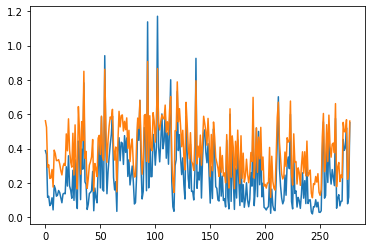

In [29]:
# Forcasting all of the X_test(280 samples)
from sklearn import tree
import calendar
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

X_train, X_test, y_train, y_test = train_test_split(Input,Target,test_size=0.4,shuffle=False)

model=tree.DecisionTreeRegressor(criterion="squared_error",max_depth = 4,min_samples_split = 2, min_samples_leaf = 23, random_state = 60) # whole week
# model=tree.DecisionTreeRegressor(criterion="squared_error",max_depth = 3,min_samples_split = 2, min_samples_leaf = 21, random_state = 60) # weekdays

model = model.fit(X_train,y_train)

size_1 = int(X_test.size/X_test[0].size)
y_all = []
MSE = [] # mean square error
MAE = [] # mean absolute error 
average_MSE = []
average_MAE = []

MAPE = []
average_MAPE = []


for i in range(size_1):
  nb_day_test = i # To be changed
  y = model.predict(X_test[nb_day_test:nb_day_test+1,:])
  y_all.append(y)
  
  MSE.append(pow((y_all[i] - y_test[i]),2)) # mean square error
  MAE.append(abs(y_all[i] - y_test[i])) # mean absolute error
  average_MSE.append(sum(sum(MSE[i])) / MSE[i].size)
  average_MAE.append(sum(sum(MAE[i])) / MAE[i].size)
  MAPE.append(abs(y_all[i] - y_test[i])/y_test[i]) # mean absolute percent error
  average_MAPE.append(sum(sum(MAPE[i])) / MAPE[i].size)


X_MSE = []
X_MAE = []
for i in range(size_1):
  X_MSE.append(i)
  X_MAE.append(i)

# Show the results of all predicted MSEs and MAEs.
plt.plot(X_MSE, average_MSE)
plt.plot(X_MAE, average_MAE)

print(sum(average_MSE))
print(sum(average_MAE))
print(sum(average_MSE)/size_1)
print(sum(average_MAE)/size_1)
print("average MAPE of all days: ", sum(average_MAPE)/size_1)

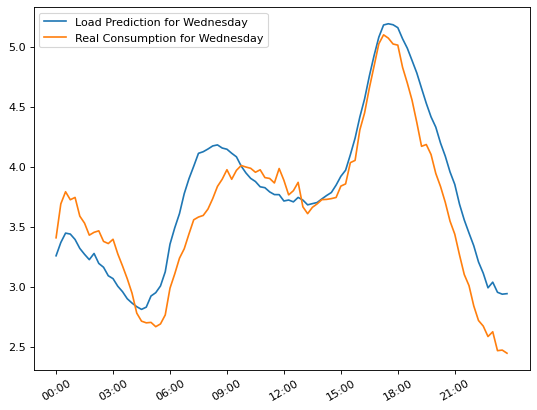

In [30]:
# Forecasting the given day
nb_day_test = 15 # To be changed
# print("expected value for charging times=\n", y_test[nb_day_test:nb_day_test+1,:])
# print("obtained value =\n", model.predict(X_test[nb_day_test:nb_day_test+1,:]))
y = model.predict(X_test[nb_day_test:nb_day_test+1,:])
time_str = []
for element in timearray_fullday:
    time_str.append(str(element)[-18:-13])


plt.figure(facecolor='w', figsize=(8, 6), dpi=80) # frame
# plot
plt.plot(time_str,y[0], label='Load Prediction for '+calendar.day_name[int(X_test[nb_day_test:nb_day_test+1,:][0,0])]) # read the first element in X_test[nb_dat_test]

plt.plot(time_str,y_test[nb_day_test:nb_day_test+1,:][0], label='Real Consumption for '+calendar.day_name[int(X_test[nb_day_test:nb_day_test+1,:][0,0])])
# beautify the x-labels
# plt.gcf().autofmt_xtime()
plt.xticks(rotation=30) # Rotate 30 degrees

x_ticks = np.arange(0, 96, 12) # (起点，终点，间距)
plt.xticks(x_ticks)
ax = plt.gca()
ax.set_facecolor('w') # background
plt.legend()
plt.show()

0.5509383834396437
0.5605018850390623


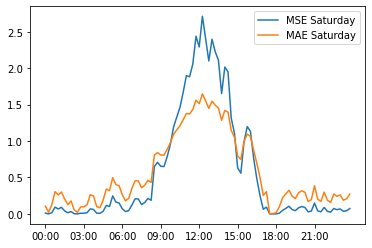

In [26]:
# Calculate the MSE and MAE of the given day

y_true = y_test[nb_day_test:nb_day_test+1,:]
MSE = pow((y - y_true),2) # mean square error
MAE = abs(y - y_true) # mean absolute error 

average_MSE = sum(MSE[0]) / MSE[0].size
average_MAE = sum(MAE[0]) / MAE[0].size
print(average_MSE)
print(average_MAE)

plt.plot(time_str, MSE[0], label='MSE '+calendar.day_name[int(X_test[nb_day_test:nb_day_test+1,:][0,0])])
plt.plot(time_str, MAE[0], label='MAE '+calendar.day_name[int(X_test[nb_day_test:nb_day_test+1,:][0,0])])

x_ticks = np.arange(0, 96, 12)
plt.xticks(x_ticks)
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
plt.show()

In [ ]:
# When "shuffle=True", calculate the averages here
number = 100
sum_MSE = 0
sum_MAE = 0
sum_MAPE = 0
for abc in range(number):
  # Forcasting all of the X_test(280 samples)
  X_train, X_test, y_train, y_test = train_test_split(Input,Target,test_size=0.4,shuffle=True)

  # model=tree.DecisionTreeRegressor(criterion="squared_error",max_depth = 4,min_samples_split = 2, min_samples_leaf = 23, random_state = 60) # whole week
  model=tree.DecisionTreeRegressor(criterion="squared_error",max_depth = 3,min_samples_split = 2, min_samples_leaf = 21, random_state = 60) # weekdays

  model = model.fit(X_train,y_train)

  size_1 = int(X_test.size/X_test[0].size)
  y_all = []
  MSE = [] # mean square error
  MAE = [] # mean absolute error 
  average_MSE = []
  average_MAE = []

  MAPE = []
  average_MAPE = []


  for i in range(size_1):
    nb_day_test = i # To be changed
    y = model.predict(X_test[nb_day_test:nb_day_test+1,:])
    y_all.append(y)
    
    MSE.append(pow((y_all[i] - y_test[i]),2)) # mean square error
    MAE.append(abs(y_all[i] - y_test[i])) # mean absolute error
    average_MSE.append(sum(sum(MSE[i])) / MSE[i].size)
    average_MAE.append(sum(sum(MAE[i])) / MAE[i].size)
    MAPE.append(abs(y_all[i] - y_test[i])/y_test[i]) # mean absolute percent error
    average_MAPE.append(sum(sum(MAPE[i])) / MAPE[i].size)

  sum_MSE = sum_MSE+sum(average_MSE)/size_1
  sum_MAE = sum_MAE+sum(average_MAE)/size_1
  sum_MAPE = sum_MAPE+sum(average_MAPE)/size_1

print(sum_MSE/number)
print(sum_MAE/number)
print("average MAPE of all days: ", sum_MAPE/number)

0.24304688637061544
0.3813641078841261
average MAPE of all days:  0.12653075360941166


149.3443233642036
249.58936046828134
The  average MSE of decision tree is:  0.21738620577031093
The  average MAE of decision tree is:  0.3633032903468433
average MAPE of all days:  0.12280330564979489


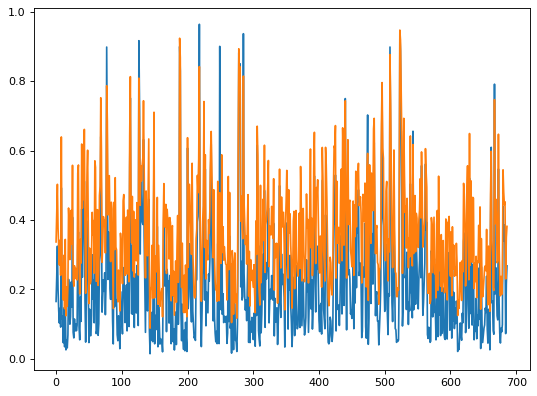

In [ ]:
# Another way to train the model: use two weeks of data to train and forcast the next day.

range_1 = 20 # Use every two weeks of data to train the model for each time
range_2 = range_1 + 1 # Forcast the next day, so totally 15 days
# model = tree.DecisionTreeRegressor(criterion="squared_error",max_depth = 1,min_samples_split = 2, min_samples_leaf = 4, random_state = 60) # whole week
model = tree.DecisionTreeRegressor(criterion="squared_error",max_depth = 1,min_samples_split = 2, min_samples_leaf = 10, random_state = 60) # weekdays


X = [] # Collect the test arrays
Y = [] # Collect the predict arrays
Y_test = [] # Collect the real arrays
size_2 = int(Input.size/Input[0].size) - range_1

for i in range(size_2):
  X_train, X_test, y_train, y_test = train_test_split(Input[i:i+range_2],Target[i:i+range_2],test_size=1/(range_2),shuffle=False)
  model = model.fit(X_train,y_train)
  y = model.predict(X_test)
  X.append(X_test)
  Y.append(y)
  Y_test.append(y_test)
  # if i == 68:
  #   XX1 = X_train
  #   XX2 = X_test
  #   YY1 = y_train
  #   YY2 = y_test
# Calculate the MSE and MAE for all predicted days

MSE = [] # mean square error
MAE = [] # mean absolute error 
average_MSE = []
average_MAE = []

MAPE = []
average_MAPE = []

for i in range(size_2):
  MSE.append(pow((Y[i] - Y_test[i]),2)) # mean square error
  MAE.append(abs(Y[i] - Y_test[i])) # mean absolute error
  average_MSE.append(sum(sum(MSE[i])) / MSE[i].size)
  average_MAE.append(sum(sum(MAE[i])) / MAE[i].size)
  MAPE.append(abs(Y[i] - Y_test[i])/Y_test[i]) # mean absolute percent error
  average_MAPE.append(sum(sum(MAPE[i])) / MAPE[i].size)

X_MSE = []
X_MAE = []
for i in range(size_2):
  X_MSE.append(i)
  X_MAE.append(i)

plt.figure(facecolor='w', figsize=(8, 6), dpi=80) # frame

# Show the results of all predicted MSEs and MAEs.
plt.plot(X_MSE, average_MSE)
plt.plot(X_MAE, average_MAE)
print(sum(average_MSE))
print(sum(average_MAE))
print("The  average MSE of decision tree is: ",sum(average_MSE)/size_2)
print("The  average MAE of decision tree is: ",sum(average_MAE)/size_2)
print("average MAPE of all days: ", sum(average_MAPE)/size_2)

In [ ]:
# Forcasting the power conpusmption of the given day.

number = 131
plt.figure(facecolor='w', figsize=(8, 6), dpi=80) # frame
# plot
plt.plot(time_str,Y[number-1][0], label='Load Prediction for '+calendar.day_name[int(X[number-1][0,0])]) 

plt.plot(time_str,Y_test[number-1][0], label='Real Consumption for '+calendar.day_name[int(X[number-1][0,0])])
# beautify the x-labels
# plt.gcf().autofmt_xtime()
plt.xticks(rotation=30) # Rotate 30 degrees


x_ticks = np.arange(0, 96, 12) 
plt.xticks(x_ticks)
ax = plt.gca()
ax.set_facecolor('w') 
plt.legend()
plt.show()

In [ ]:
# Calculate the MSE and MAE for all predicted days

MSE = [] # mean square error
MAE = [] # mean absolute error 
average_MSE = []
average_MAE = []

for i in range(size_2):
  MSE.append(pow((Y[i] - Y_test[i]),2)) # mean square error
  MAE.append(abs(Y[i] - Y_test[i])) # mean absolute error
  average_MSE.append(sum(sum(MSE[i])) / MSE[i].size)
  average_MAE.append(sum(sum(MAE[i])) / MAE[i].size)

X_MSE = []
X_MAE = []
for i in range(size_2):
  X_MSE.append(i)
  X_MAE.append(i)

plt.figure(facecolor='w', figsize=(8, 6), dpi=80) # frame

# Show the results of all predicted MSEs and MAEs.
plt.plot(X_MSE, average_MSE)
plt.plot(X_MAE, average_MAE)
print(sum(average_MSE))
print(sum(average_MAE))
print("The  average MSE of decision tree is: ",sum(average_MSE)/size_2)
print("The  average MAE of decision tree is: ",sum(average_MAE)/size_2)

# plt.plot(time_str, MSE[number-1][0], label='MSE '+calendar.day_name[int(X[number-1][0,0])])
# plt.plot(time_str, MAE[number-1][0], label='MAE '+calendar.day_name[int(X[number-1][0,0])])
# x_ticks = np.arange(0, 96, 12)
# plt.xticks(x_ticks)
# ax = plt.gca()
# ax.set_facecolor('w')
# plt.legend()
# plt.show()


In [ ]:
# grid search (for method_1: 419+280)
# ScoreAll = []
# score = -1
ii = 0
jj = 0
kk = 0
i = 0
min = 1000
MSE = []
X_train, X_test, y_train, y_test = train_test_split(Input,Target,test_size=0.4,shuffle=False)

for i in range(1,10,1):
  print(i)
  print(ii,jj,kk,min) 
  for j in range(2,20,1):
    for k in range(1,30,1):
      S = 0
      model=tree.DecisionTreeRegressor(criterion="squared_error",max_depth = i,min_samples_split = j, min_samples_leaf = k, random_state = 60) # squared_error, absolute_error
      model.fit(X_train,y_train)
      # S = cross_val_score(model,X_train,y_train,cv=10).mean()
      # S = model.score(X_train,y_train) + model.score(X_test,y_test)
      # S = model.score(X_test,y_test)
      Y = model.predict(X_test)
      MSE = pow((Y - y_test),2) # New definition of the score
      S = sum(sum(MSE))/MSE.size
      if min > S:
        ii = i
        jj = j
        kk = k
        min = S

print(ii,jj,kk,min)  

1
0 0 0 1000
2
1 2 1 0.4194666967134203
3
2 2 1 0.29485520889207734
4
3 2 21 0.2635055011692639
5
3 2 21 0.2635055011692639
6
3 2 21 0.2635055011692639
7
3 2 21 0.2635055011692639
8
3 2 21 0.2635055011692639
9
3 2 21 0.2635055011692639
3 2 21 0.2635055011692639


In [ ]:
# # grid search (for the other method: 7+1)
for abc in range(8,9,1):
  ii = 0
  jj = 0
  kk = 0



  min = 1000
  range_1 = abc
  range_2 = range_1+1
  size_2 = int(Input.size/Input[0].size) - range_1

  print(abc)
  for i in range(1,2,1):
    # print(i)
    # print(ii,jj,kk,min) 
    for j in range(2,3,1):
      for k in range(5,6,1):
        S = 0
        model=tree.DecisionTreeRegressor(criterion="squared_error",max_depth = i,min_samples_split = j, min_samples_leaf = k, random_state = 60) # squared_error, absolute_error
        for num in range(size_2):
          X_train, X_test, y_train, y_test = train_test_split(Input[num:num+range_2],Target[num:num+range_2],test_size=1/(range_2),shuffle=False)
          MSE = []
          model.fit(X_train,y_train)
          Y = model.predict(X_test)
          MSE = pow((Y - y_test),2) # New definition of the score
          S = S + sum(sum(MSE))/MSE.size
        if min > S/size_2:
          ii = i
          jj = j
          kk = k
          min = S/size_2
        print(i,j,k,min) 
  print(ii,jj,kk,min) 

8
1 2 5 0.21738620577031093
1 2 5 0.21738620577031093


In [ ]:
# 20 1 2 10 0.21326758159652495
# 15 1 2 7 0.2195818715676742

In [ ]:
# Compare the performance of the model with a different series of parameters by "model.score"

X_train, X_test, y_train, y_test = train_test_split(Input,Target,test_size=0.4,shuffle=True)

model_1=tree.DecisionTreeRegressor(max_depth = 5,min_samples_split = 69, min_samples_leaf = 18, random_state = 60) # squared_error, absolute_error
model_1.fit(X_train,y_train)
model_1_score1 = model_1.score(X_train,y_train)
model_1.fit(X_test,y_test)
model_1_score2 = model_1.score(X_test,y_test)
Score_1 = model_1_score1+model_1_score2
print(Score_1)

model_2=tree.DecisionTreeRegressor(max_depth = 5,min_samples_split = 2, min_samples_leaf = 15, random_state = 60) # squared_error, absolute_error
model_2.fit(X_train,y_train)
model_2_score1 = model_2.score(X_train,y_train)
model_2.fit(X_test,y_test)
model_2_score2 = model_2.score(X_test,y_test)
Score_2 = model_2_score1+model_2_score2
print(Score_2)


In [ ]:
# The third method to train and test the model(90 days) (didn't use)

accuracy_1 = [] # Store the MSE of the different models
accuracy_2 = [] # Store the MAE of the different models

for length_3 in range(90,200):
  size_3 = length_3 - 14
  X_test, X_train, y_test, y_train = train_test_split(Input[0:length_3],Target[0:length_3],test_size=14,shuffle=False) 
  # Because I exchanged the positions of "train" and "test"(so as to let the latter part of data to be the train data), "test_size" is the size of train data.
  # Use the last two weeks of data to train the model, and use the rest data to test the model
  model_3 = tree.DecisionTreeRegressor(criterion="absolute_error",max_depth = 5,min_samples_split = 2, min_samples_leaf = 15, random_state = 60)
  model_3 = model_3.fit(X_train,y_train)
  Y_3 = model_3.predict(X_test)

  MSE_3 = pow((Y_3 - y_test),2)
  MAE_3 = abs(Y_3 - y_test)
  average_MSE_3 = []
  average_MAE_3 = []

  for i in range(size_3):
    average_MSE_3.append(sum(MSE_3[i]) / MSE_3[i].size)
    average_MAE_3.append(sum(MAE_3[i]) / MAE_3[i].size)
  accuracy_1.append(sum(average_MSE_3)/size_3)
  accuracy_2.append(sum(average_MAE_3)/size_3)


X_MSE = []
X_MAE = []
for i in range(200-90):
  X_MSE.append(i)
  X_MAE.append(i)

plt.plot(X_MSE, accuracy_1)
# plt.plot(X_MAE, accuracy_2)

# plt.figure(facecolor='w', figsize=(8, 6), dpi=80) # frame

# # Show the results of all predicted MSEs and MAEs.
# plt.plot(X_MSE, average_MSE_3)
# plt.plot(X_MAE, average_MAE_3)
# print(sum(average_MSE_3))
# print(sum(average_MAE_3))
# print(sum(average_MSE_3)/size_3)
# print(sum(average_MAE_3)/size_3)

In [ ]:
length_3 = 90
# X_train, X_test, y_train, y_test = train_test_split(Input[0:length_3],Target[0:length_3],train_size=14,shuffle=False) 
X_test, X_train, y_test, y_train = train_test_split(Input[0:length_3],Target[0:length_3],test_size=14,shuffle=False) 

print(X_train)
Input[76:90]

# Random Forest

In [31]:
!pip install sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(Input,Target,test_size=0.4,shuffle=True)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


69.42764132111867
107.38426880281528
0.24973971698244127
0.38627434821156575
average MAPE of all days:  0.1271117289174218


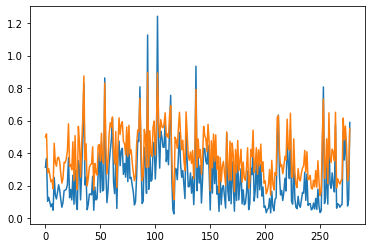

In [33]:
# Forcasting all of the X_test(280 samples)
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(Input,Target,test_size=0.4,shuffle=False)
model = RandomForestRegressor(n_estimators = 57, criterion="squared_error", max_depth = 4, min_samples_split = 2, min_samples_leaf = 11, random_state = 6) # the whole week   
# model = RandomForestRegressor(n_estimators = 11, criterion="squared_error",max_depth = 4, min_samples_split = 17, min_samples_leaf = 1, random_state = 6) # weekdays
model = model.fit(X_train,y_train)

size_1 = int(X_test.size/X_test[0].size)
y_all = []
MSE = [] # mean square error
MAE = [] # mean absolute error 
average_MSE = []
average_MAE = []
MAPE = []
average_MAPE = []

Y = model.predict(X_test)
period_MSE = pow((Y - y_test),2)
period_MAE = abs(Y - y_test)
period_MAPE = abs(Y - y_test)/y_test

for i in range(size_1):  
  average_MSE.append(sum(period_MSE[i]) / period_MSE[i].size)
  average_MAE.append(sum(period_MAE[i]) / period_MAE[i].size)
  average_MAPE.append(sum(period_MAPE[i]) / period_MAPE[i].size)


X_MSE = []
X_MAE = []
for i in range(size_1):
  X_MSE.append(i)
  X_MAE.append(i)

# Show the results of all predicted MSEs and MAEs.
plt.plot(X_MSE, average_MSE)
plt.plot(X_MAE, average_MAE)

print(sum(average_MSE))
print(sum(average_MAE))
print(sum(average_MSE)/size_1)
print(sum(average_MAE)/size_1)
print("average MAPE of all days: ", sum(average_MAPE)/size_1)


In [ ]:
# When "shuffle=True", calculate the averages here
# Forcasting all of the X_test(280 samples)

number = 100
sum_MSE = 0
sum_MAE = 0
sum_MAPE = 0
for abc in range(number):
  
  X_train, X_test, y_train, y_test = train_test_split(Input,Target,test_size=0.4,shuffle=True)
  # model = RandomForestRegressor(n_estimators = 57, criterion="squared_error", max_depth = 4, min_samples_split = 2, min_samples_leaf = 11, random_state = 6) # the whole week   
  model = RandomForestRegressor(n_estimators = 11, criterion="squared_error",max_depth = 4, min_samples_split = 19, min_samples_leaf = 3, random_state = 6) # weekdays
  model = model.fit(X_train,y_train)

  size_1 = int(X_test.size/X_test[0].size)
  y_all = []
  MSE = [] # mean square error
  MAE = [] # mean absolute error 
  average_MSE = []
  average_MAE = []
  MAPE = []
  average_MAPE = []

  Y = model.predict(X_test)
  period_MSE = pow((Y - y_test),2)
  period_MAE = abs(Y - y_test)
  period_MAPE = abs(Y - y_test)/y_test

  for i in range(size_1):  
    average_MSE.append(sum(period_MSE[i]) / period_MSE[i].size)
    average_MAE.append(sum(period_MAE[i]) / period_MAE[i].size)
    average_MAPE.append(sum(period_MAPE[i]) / period_MAPE[i].size)

  sum_MSE = sum_MSE+sum(average_MSE)/size_1
  sum_MAE = sum_MAE+sum(average_MAE)/size_1
  sum_MAPE = sum_MAPE+sum(average_MAPE)/size_1


print(sum_MSE/number)
print(sum_MAE/number)
print("average MAPE of all days: ", sum_MAPE/number)

0.22877348774850673
0.37022813859840553
average MAPE of all days:  0.12393361081725594


In [ ]:
# Search for the best value for one parameter in the model(280/698)

S = 0
ii = 0
min = 1000
X_train, X_test, y_train, y_test = train_test_split(Input,Target,test_size=0.4,shuffle=False)

for i in range(1,10,1):
    model = RandomForestRegressor(n_estimators = 87, max_depth = 5, min_samples_split = 19, min_samples_leaf = i, random_state = 140)    
    MSE = []
    model.fit(X_train,y_train)
    Y = model.predict(X_test)
    MSE = pow((Y - y_test),2) # New definition of the score
    S = sum(sum(MSE))/MSE.size
    # print(S)
    if min > S:
      ii = i
      min = S

print(ii,min)

5 0.25043709469787173


In [ ]:
# grid search (280/698)
S = 0
ii = 0
jj = 0
kk = 0
ll = 0
min = 1000
X_train, X_test, y_train, y_test = train_test_split(Input,Target,test_size=0.4,shuffle=False)

for i in range(126,127,1):
  for j in range(4,5,1):
    for k in range(18,19,1):
      for l in range(5,6,1):
        model = RandomForestRegressor(n_estimators = i, max_depth = j, min_samples_split = k, min_samples_leaf = l, random_state = 6)    
        MSE = []
        model.fit(X_train,y_train)
        Y = model.predict(X_test)
        MSE = pow((Y - y_test),2) # New definition of the score
        S = sum(sum(MSE))/MSE.size
        print(i,j,k,l,S) 
        if min > S:
          ii = i
          jj = j
          kk = k
          ll = l
          min = S

print(ii,jj,kk,ll,min) 

11 4 17 1 0.2505977439792245


In [ ]:
# 11 4 17 1 0.2505977439792245

In [35]:
# Another way to train the model: use two weeks of data to train and forcast the next day.

# range_1 = 28 # Use every two weeks of data to train the model for each time
# range_2 = range_1 + 1 # Forcast the next day, so totally 15 days
# model = RandomForestRegressor(n_estimators = 41, criterion="squared_error", max_depth = 2, min_samples_split = 12, min_samples_leaf = 2, random_state = 140)    
# X = [] # Collect the test arrays
# Y = [] # Collect the predict arrays
# Y_test = [] # Collect the real arrays
# size_2 = int(Input.size/Input[0].size) - range_1
# # size_2 = 10
# score1 = 0
# score2 = 0
# for i in range(size_2):
#   # X_train, X_test, y_train, y_test = train_test_split(input_test[i:i+range_2],target_test[i:i+range_2],test_size=1/(range_2),shuffle=False)
#   X_train, X_test, y_train, y_test = train_test_split(Input[i:i+range_2],Target[i:i+range_2],test_size=1/(range_2),shuffle=False)
#   model = model.fit(X_train,y_train)
#   y = model.predict(X_test)
#   X.append(X_test)
#   Y.append(y)
#   Y_test.append(y_test)
#   print(i)

# multiple tests

# Average_MSE = []
# Average_MAE = []
# Average_MAPE = []


for abc in range(1):

  range_1 = 15 # Use every two weeks of data to train the model for each time
  range_2 = range_1 + 1 # Forcast the next day, so totally 15 days
  # model = RandomForestRegressor(n_estimators = 41, criterion="squared_error", max_depth = 2, min_samples_split = 2, min_samples_leaf = 3, random_state = 131) # the whole week(28+1)
  model = RandomForestRegressor(n_estimators = 37, criterion="squared_error", max_depth = 1, min_samples_split = 2, min_samples_leaf = 3, random_state = 143) # weekdays(15+1)
   
  X = [] # Collect the test arrays
  Y = [] # Collect the predict arrays
  Y_test = [] # Collect the real arrays
  size_2 = int(Input.size/Input[0].size) - range_1
# size_2 = 10
  for i in range(size_2):
    # X_train, X_test, y_train, y_test = train_test_split(input_test[i:i+range_2],target_test[i:i+range_2],test_size=1/(range_2),shuffle=False)
    X_train, X_test, y_train, y_test = train_test_split(Input[i:i+range_2],Target[i:i+range_2],test_size=1/(range_2),shuffle=False)
    model = model.fit(X_train,y_train)
    y = model.predict(X_test)
    X.append(X_test)
    Y.append(y)
    Y_test.append(y_test)
  # print(i)

  MSE = [] # mean square error
  MAE = [] # mean absolute error 
  average_MSE = []
  average_MAE = []
  MAPE = []
  average_MAPE = []

  for i in range(size_2):
    MSE.append(pow((Y[i] - Y_test[i]),2)) # mean square error
    MAE.append(abs(Y[i] - Y_test[i])) # mean absolute error
    average_MSE.append(sum(sum(MSE[i])) / MSE[i].size)
    average_MAE.append(sum(sum(MAE[i])) / MAE[i].size)
    MAPE.append(abs(Y[i] - Y_test[i])/Y_test[i]) 
    average_MAPE.append(sum(sum(MAPE[i])) / MAPE[i].size)

  # Average_MSE.append(sum(average_MSE)/size_2)
  # Average_MAE.append(sum(average_MAE)/size_2)
  # Average_MAPE.append(sum(average_MAPE)/size_2)

  print(abc)
  print(sum(average_MSE)/size_2)
  print(sum(average_MAE)/size_2)
  print("average MAPE of all days: ", sum(average_MAPE)/size_2)


0
0.21012870900903488
0.3535012289095154
average MAPE of all days:  0.11999899569092119


In [ ]:
# When "shuffle=True", calculate the averages here
# Forcasting all of the X_test(280 samples)

number = 20
sum_MSE = 0
sum_MAE = 0
sum_MAPE = 0
for abc in range(number):
  print(abc)
  
  range_1 = 15 # Use every two weeks of data to train the model for each time
  range_2 = range_1 + 1 # Forcast the next day, so totally 15 days
  # model = RandomForestRegressor(n_estimators = 41, criterion="squared_error", max_depth = 2, min_samples_split = 2, min_samples_leaf = 3, random_state = 131) # the whole week(28+1)
  model = RandomForestRegressor(n_estimators = 37, criterion="squared_error", max_depth = 1, min_samples_split = 2, min_samples_leaf = 3, random_state = 143) # weekdays(15+1)
   
  X = [] # Collect the test arrays
  Y = [] # Collect the predict arrays
  Y_test = [] # Collect the real arrays
  size_2 = int(Input.size/Input[0].size) - range_1
# size_2 = 10
  for i in range(size_2):
    # X_train, X_test, y_train, y_test = train_test_split(input_test[i:i+range_2],target_test[i:i+range_2],test_size=1/(range_2),shuffle=False)
    X_train, X_test, y_train, y_test = train_test_split(Input[i:i+range_2],Target[i:i+range_2],test_size=1/(range_2),shuffle=True)
    model = model.fit(X_train,y_train)
    y = model.predict(X_test)
    X.append(X_test)
    Y.append(y)
    Y_test.append(y_test)
  # print(i)

  MSE = [] # mean square error
  MAE = [] # mean absolute error 
  average_MSE = []
  average_MAE = []
  MAPE = []
  average_MAPE = []

  for i in range(size_2):
    MSE.append(pow((Y[i] - Y_test[i]),2)) # mean square error
    MAE.append(abs(Y[i] - Y_test[i])) # mean absolute error
    average_MSE.append(sum(sum(MSE[i])) / MSE[i].size)
    average_MAE.append(sum(sum(MAE[i])) / MAE[i].size)
    MAPE.append(abs(Y[i] - Y_test[i])/Y_test[i]) 
    average_MAPE.append(sum(sum(MAPE[i])) / MAPE[i].size)

  sum_MSE = sum_MSE+sum(average_MSE)/size_2
  sum_MAE = sum_MAE+sum(average_MAE)/size_2
  sum_MAPE = sum_MAPE+sum(average_MAPE)/size_2


print(sum_MSE/number)
print(sum_MAE/number)
print("average MAPE of all days: ", sum_MAPE/number)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0.1983569986365819
0.34379252192647286
average MAPE of all days:  0.11493490537966582


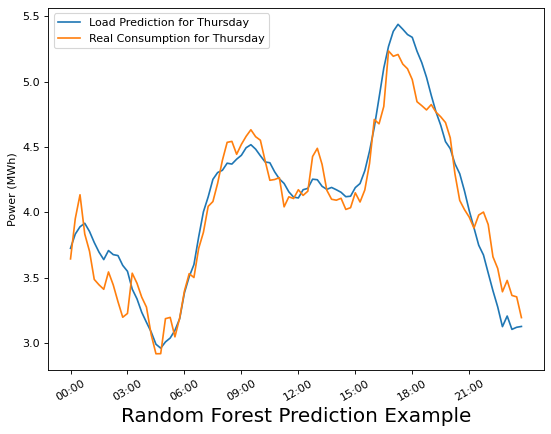

In [ ]:
# Forcasting the power conpusmption of the given day.

number = 19
plt.figure(facecolor='w', figsize=(8, 6), dpi=80) # frame
# plot
plt.plot(time_str,Y[number-1][0], label='Load Prediction for '+calendar.day_name[int(X[number-1][0,0])]) 

plt.plot(time_str,Y_test[number-1][0], label='Real Consumption for '+calendar.day_name[int(X[number-1][0,0])])
# beautify the x-labels
# plt.gcf().autofmt_xtime()
plt.xticks(rotation=30) # Rotate 30 degrees

font1 = {'family' : 'Times New Roman', 'weight' : 'normal', 'size': 10,}
font2 = {'family' : 'Times New Roman', 'weight' : 'normal', 'size': 18,}

plt.xlabel("Random Forest Prediction Example",font2)         
plt.ylabel(r"Power (MWh)",font1) 
x_ticks = np.arange(0, 96, 12) 
plt.xticks(x_ticks)
ax = plt.gca()
ax.set_facecolor('w') 
plt.legend()
plt.show()

125.02752708898994
222.77542782668357
The  average MSE is:  0.1874475668500599
The  average MAE is:  0.33399614366819125
average MAPE of all days:  0.10989893758641729


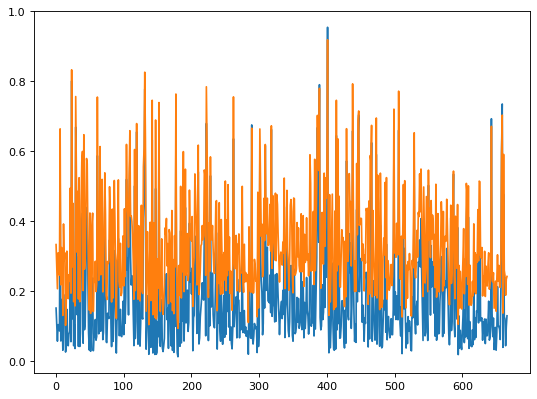

In [ ]:
# Calculate the MSE and MAE for all predicted days

MSE = [] # mean square error
MAE = [] # mean absolute error 
average_MSE = []
average_MAE = []

MAPE = []
average_MAPE = []

for i in range(size_2):
  MSE.append(pow((Y[i] - Y_test[i]),2)) # mean square error
  MAE.append(abs(Y[i] - Y_test[i])) # mean absolute error
  average_MSE.append(sum(sum(MSE[i])) / MSE[i].size)
  average_MAE.append(sum(sum(MAE[i])) / MAE[i].size)

  MAPE.append(abs(Y[i] - Y_test[i])/Y_test[i]) # mean absolute percent error
  average_MAPE.append(sum(sum(MAPE[i])) / MAPE[i].size)


X_MSE = []
X_MAE = []
for i in range(size_2):
  X_MSE.append(i)
  X_MAE.append(i)

plt.figure(facecolor='w', figsize=(8, 6), dpi=80) # frame

# Show the results of all predicted MSEs and MAEs.
plt.plot(X_MSE, average_MSE)
plt.plot(X_MAE, average_MAE)
print(sum(average_MSE))
print(sum(average_MAE))
print("The  average MSE is: ",sum(average_MSE)/size_2)
print("The  average MAE is: ",sum(average_MAE)/size_2)
print("average MAPE of all days: ", sum(average_MAPE)/size_2)

# plt.plot(time_str, MSE[number-1][0], label='MSE '+calendar.day_name[int(X[number-1][0,0])])
# plt.plot(time_str, MAE[number-1][0], label='MAE '+calendar.day_name[int(X[number-1][0,0])])
# x_ticks = np.arange(0, 96, 12)
# plt.xticks(x_ticks)
# ax = plt.gca()
# ax.set_facecolor('w')
# plt.legend()
# plt.show()


In [9]:
# # grid search (for the other method: 14+1)
for abc in range(1,36,1):
  print(abc)
  ii = 0
  jj = 0
  kk = 0
  ll = 0

  min = 1000
  range_1 = abc
  range_2 = range_1+1

  size_2 = int(Input.size/Input[0].size) - range_1
  for i in range(40,41,1):
    for j in range(2,3,1):
      for k in range(8,9,1):
        for l in range(1,2,1):
          S = 0
          model = RandomForestRegressor(criterion="squared_error", n_estimators = i, max_depth = j, min_samples_split = k, min_samples_leaf = l, random_state = 6)    
          for num in range(size_2):
            X_train, X_test, y_train, y_test = train_test_split(Input[num:num+range_2],Target[num:num+range_2],test_size=1/(range_2),shuffle=False)
            MSE = []
            model.fit(X_train,y_train)
            Y = model.predict(X_test)
            MSE = pow((Y - y_test),2) # New definition of the score
            S = S + sum(sum(MSE))/MSE.size
          print(i,j,k,l,S/size_2)
          if min > S/size_2:
            ii = i
            jj = j
            kk = k
            ll = l
            min = S/size_2

  print(ii,jj,kk,ll,min)  

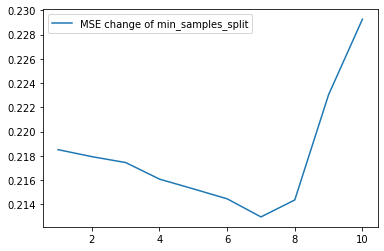

In [ ]:
X = [1,2,3,4,5,6,7,8,9,10]
plt.plot(X, num_of_tree, label='MSE change of min_samples_split')
plt.legend()
plt.show()

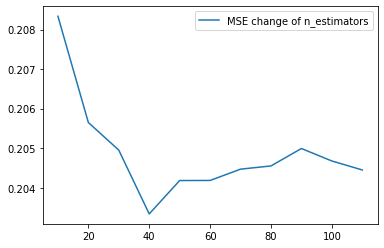

In [ ]:
X = [10,20,30,40,50,60,70,80,90,100,110]

plt.plot(X, num_of_tree, label='MSE change of n_estimators')
plt.legend()
plt.show()

# kNN

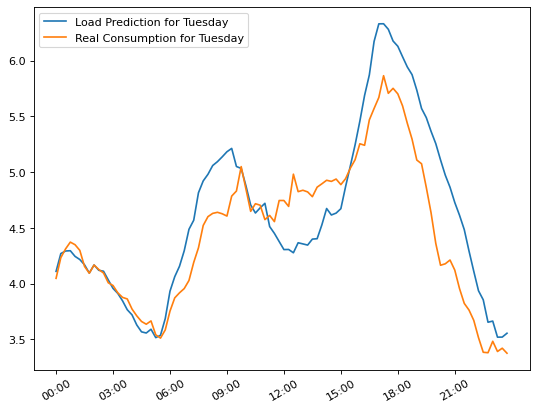

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

X_train, X_test, y_train, y_test = train_test_split(Input,Target,test_size=0.4,shuffle=False)

number_of_neighbors = 15  # To be changed
model= KNeighborsRegressor(n_neighbors=2)
model = model.fit(X_train,y_train)

nb_day_test = 20 # To be changed
# print("expected value for charging times=\n", y_test[nb_day_test:nb_day_test+1,:])
# print("obtained value =\n", model.predict(X_test[nb_day_test:nb_day_test+1,:]))
y = model.predict(X_test[nb_day_test:nb_day_test+1,:])
time_str = []
for element in timearray_fullday:
    time_str.append(str(element)[-18:-13])


plt.figure(facecolor='w', figsize=(8, 6), dpi=80)
# plot
plt.plot(time_str,y[0], label='Load Prediction for '+calendar.day_name[int(X_test[nb_day_test:nb_day_test+1,:][0,0])])

plt.plot(time_str,y_test[nb_day_test:nb_day_test+1,:][0], label='Real Consumption for '+calendar.day_name[int(X_test[nb_day_test:nb_day_test+1,:][0,0])])
# beautify the x-labels
# plt.gcf().autofmt_xtime()
plt.xticks(rotation=30)


x_ticks = np.arange(0, 96, 12)
plt.xticks(x_ticks)
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
plt.show()

69.60189719046184
108.97382466330733
0.25036653665633757
0.3919921750478681
average MAPE of all days:  0.13500773301334398


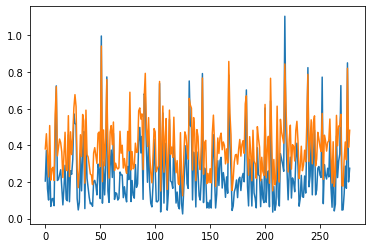

In [ ]:
# Forcasting all of the X_test(280 samples)

X_train, X_test, y_train, y_test = train_test_split(Input,Target,test_size=0.4,shuffle=True)

model= KNeighborsRegressor(p=1, n_neighbors=20, weights='uniform') # the whole week
# model= KNeighborsRegressor(p=2, n_neighbors=30, weights='uniform') # weekdays
model = model.fit(X_train,y_train)

size_1 = int(X_test.size/X_test[0].size)
y_all = []
MSE = [] # mean square error
MAE = [] # mean absolute error 
average_MSE = []
average_MAE = []
MAPE = []
average_MAPE = []

Y = model.predict(X_test)
period_MSE = pow((Y - y_test),2)
period_MAE = abs(Y - y_test)
period_MAPE = abs(Y - y_test)/y_test


for i in range(size_1):  
  average_MSE.append(sum(period_MSE[i]) / period_MSE[i].size)
  average_MAE.append(sum(period_MAE[i]) / period_MAE[i].size)
  average_MAPE.append(sum(period_MAPE[i]) / period_MAPE[i].size)

X_MSE = []
X_MAE = []
for i in range(size_1):
  X_MSE.append(i)
  X_MAE.append(i)

# Show the results of all predicted MSEs and MAEs.
plt.plot(X_MSE, average_MSE)
plt.plot(X_MAE, average_MAE)

print(sum(average_MSE))
print(sum(average_MAE))
print(sum(average_MSE)/size_1)
print(sum(average_MAE)/size_1)
print("average MAPE of all days: ", sum(average_MAPE)/size_1)


In [ ]:
# When "shuffle=True", calculate the averages here
# Forcasting all of the X_test(280 samples)

number = 100
sum_MSE = 0
sum_MAE = 0
sum_MAPE = 0
for abc in range(number):
  
  # print(abc)
  X_train, X_test, y_train, y_test = train_test_split(Input,Target,test_size=0.4,shuffle=True)

  # model= KNeighborsRegressor(p=1, n_neighbors=20, weights='uniform') # the whole week
  model= KNeighborsRegressor(p=2, n_neighbors=30, weights='uniform') # weekdays
  model = model.fit(X_train,y_train)

  size_1 = int(X_test.size/X_test[0].size)
  y_all = []
  MSE = [] # mean square error
  MAE = [] # mean absolute error 
  average_MSE = []
  average_MAE = []
  MAPE = []
  average_MAPE = []

  Y = model.predict(X_test)
  period_MSE = pow((Y - y_test),2)
  period_MAE = abs(Y - y_test)
  period_MAPE = abs(Y - y_test)/y_test


  for i in range(size_1):  
    average_MSE.append(sum(period_MSE[i]) / period_MSE[i].size)
    average_MAE.append(sum(period_MAE[i]) / period_MAE[i].size)
    average_MAPE.append(sum(period_MAPE[i]) / period_MAPE[i].size)

  sum_MSE = sum_MSE+sum(average_MSE)/size_1
  sum_MAE = sum_MAE+sum(average_MAE)/size_1
  sum_MAPE = sum_MAPE+sum(average_MAPE)/size_1


print(sum_MSE/number)
print(sum_MAE/number)
print("average MAPE of all days: ", sum_MAPE/number)

0.22960438197611552
0.37181544891744045
average MAPE of all days:  0.1256106387139119


In [ ]:
# Search for the best value for one parameter in the model(280/698)

S = 0
ii = 0
jj = 0
min = 1000
X_train, X_test, y_train, y_test = train_test_split(Input,Target,test_size=0.4,shuffle=False)

for i in range(1,3,1):
  for j in range(1,100,1): #(1,int(X_train.size/X_train[0].size)+1,1)
    model= KNeighborsRegressor(p=i, n_neighbors=j, weights='uniform')
    # 'algorithm' and 'leaf_size' only affect the speed of computing 
    # p=1, metric='manhattan'. p=2, metric='euclidean'
    MSE = []
    model.fit(X_train,y_train)
    Y = model.predict(X_test)
    MSE = pow((Y - y_test),2) # New definition of the score
    S = sum(sum(MSE))/MSE.size
    # print(S)
    if min > S:
      ii = i
      jj = j
      min = S

print(ii,jj,min)

1 37 0.2626711099259923


139.61966683952383
237.0714398278183
The  average MSE is:  0.20963913939868442
The  average MAE is:  0.35596312286459203
average MAPE of all days:  0.12198295493383764


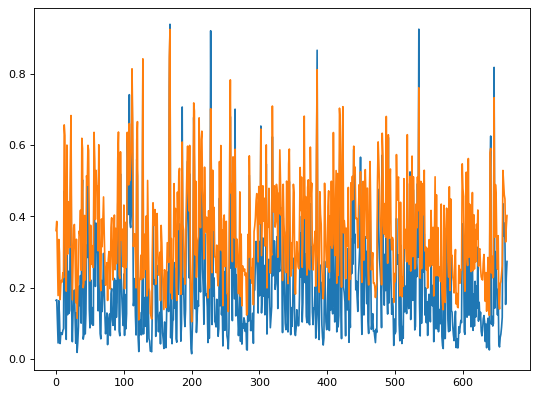

In [ ]:
# Another way to train the model: use two weeks of data to train and forcast the next day.

range_1 = 29 # Use every two weeks of data to train the model for each time
range_2 = range_1 + 1 # Forcast the next day, so totally 15 days
model= KNeighborsRegressor(p=2, n_neighbors=13, weights='distance') # the whole week
# model= KNeighborsRegressor(p=2, n_neighbors=10, weights='distance') # weekdays(20+1)
X = [] # Collect the test arrays
Y = [] # Collect the predict arrays
Y_test = [] # Collect the real arrays
size_2 = int(Input.size/Input[0].size) - range_1
# size_2 = 10
for i in range(size_2):
  # X_train, X_test, y_train, y_test = train_test_split(input_test[i:i+range_2],target_test[i:i+range_2],test_size=1/(range_2),shuffle=False)
  X_train, X_test, y_train, y_test = train_test_split(Input[i:i+range_2],Target[i:i+range_2],test_size=1/(range_2),shuffle=False)
  model = model.fit(X_train,y_train)
  y = model.predict(X_test)
  X.append(X_test)
  Y.append(y)
  Y_test.append(y_test)

# Calculate the MSE and MAE for all predicted days

MSE = [] # mean square error
MAE = [] # mean absolute error 
average_MSE = []
average_MAE = []
MAPE = []
average_MAPE = []

for i in range(size_2):
  MSE.append(pow((Y[i] - Y_test[i]),2)) # mean square error
  MAE.append(abs(Y[i] - Y_test[i])) # mean absolute error
  average_MSE.append(sum(sum(MSE[i])) / MSE[i].size)
  average_MAE.append(sum(sum(MAE[i])) / MAE[i].size)
  MAPE.append(abs(Y[i] - Y_test[i])/Y_test[i]) # mean absolute percent error
  average_MAPE.append(sum(sum(MAPE[i])) / MAPE[i].size)

X_MSE = []
X_MAE = []
for i in range(size_2):
  X_MSE.append(i)
  X_MAE.append(i)

plt.figure(facecolor='w', figsize=(8, 6), dpi=80) # frame

# Show the results of all predicted MSEs and MAEs.
plt.plot(X_MSE, average_MSE)
plt.plot(X_MAE, average_MAE)
print(sum(average_MSE))
print(sum(average_MAE))
print("The  average MSE is: ",sum(average_MSE)/size_2)
print("The  average MAE is: ",sum(average_MAE)/size_2)
print("average MAPE of all days: ", sum(average_MAPE)/size_2)


In [ ]:
# # grid search (for the other method: 14+1)

for abc in range(1,36,1):
  print(abc)
  ii = 0
  jj = 0
  num_of_tree = []
  i = 0
  min = 1000
  range_1 = abc
  range_2 = range_1+1

  X_train, X_test, y_train, y_test = train_test_split(Input[i:i+range_2],Target[i:i+range_2],test_size=1/(range_2),shuffle=False)
  size_2 = int(Input.size/Input[0].size) - range_1
  for i in range(1,3,1):
    for j in range(1,range_2,1):
      S = 0
      model= KNeighborsRegressor(p=i, n_neighbors=j, weights='distance')
      for num in range(size_2):
        X_train, X_test, y_train, y_test = train_test_split(Input[num:num+range_2],Target[num:num+range_2],test_size=1/(range_2),shuffle=False)
        MSE = []
        model.fit(X_train,y_train)
        Y = model.predict(X_test)
        MSE = pow((Y - y_test),2) # New definition of the score
        S = S + sum(sum(MSE))/MSE.size
      # print(S/size_2)
      num_of_tree.append(S/size_2)
      if min > S:
        ii = i
        jj = j
        min = S

  print(ii,jj,min/size_2)  

1
1 1 0.2724352880081036
2
1 2 0.24121663755242562
3
1 3 0.23607091245569994
4
1 4 0.22862665491478643
5
1 5 0.2239003988053656
6
1 6 0.22069092195878573
7
1 7 0.21494635964647785
8
1 8 0.2137870910616025
9
1 9 0.21479581313111817
10
1 10 0.21695038096018174
11
1 7 0.21855477473724064
12
2 8 0.21905594204314854
13
2 8 0.21763536912702133
14
2 9 0.2151308445491122
15
1 11 0.21367975839982156
16
2 10 0.2123334210095772
17
2 10 0.21279963425837062
18
1 11 0.21362874093609957
19
1 11 0.21506825485778983
20
2 11 0.21515711083233025
21
2 12 0.21329977058681085
22
2 12 0.21192787803968655
23
2 12 0.21144326700247804
24
2 12 0.21124462683217216
25
2 13 0.21217042571417385
26
1 11 0.21209506284893287
27
1 11 0.21203478399947953
28
2 10 0.21037408018368092
29
2 13 0.20963913939868442
30
2 11 0.2098841959756142
31
2 12 0.2099182989601255
32
2 13 0.21035740920815055
33
2 13 0.2116598322563705
34
2 13 0.2129318002340382
35
2 13 0.21304888885462647


# Artificial Neural Networks 

#ANN using sklearn standard library

In [36]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(hidden_layer_sizes=(100,200,500,100,200), random_state=1)  # change the number of layers and the number of neurons

model = model.fit(X_train,y_train)  



65.03339836289224
105.41194486845785
0.23393308763630302
0.3791796578002081
average MAPE of all days:  0.12361107688333152


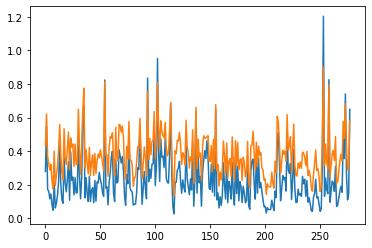

In [38]:
# Forcasting all of the X_test(280 samples)
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(Input,Target,test_size=0.4,shuffle=False)

model = MLPRegressor(hidden_layer_sizes=(140,10,10,160), activation='relu', solver='adam', 
alpha=0.0001, batch_size=130, learning_rate_init=0.001, max_iter=200, tol=0.0001, 
random_state=1, early_stopping=False, validation_fraction=0.1) # whole week

# model = MLPRegressor(hidden_layer_sizes=(144,10,10,158), activation='relu', solver='adam', 
# alpha=0.0001, batch_size=130, learning_rate_init=0.001, max_iter=200, tol=0.0001, 
# random_state=1, early_stopping=False, validation_fraction=0.1) # weekdays

model = model.fit(X_train,y_train)  

size_1 = int(X_test.size/X_test[0].size)
y_all = []
MSE = [] # mean square error
MAE = [] # mean absolute error 
average_MSE = []
average_MAE = []
MAPE = []
average_MAPE = []

Y = model.predict(X_test)
period_MSE = pow((Y - y_test),2)
period_MAE = abs(Y - y_test)
period_MAPE = abs(Y - y_test)/y_test

# score1 = model.score(X_train,y_train)
# score2 = model.score(X_test,y_test)

for i in range(size_1):  
  average_MSE.append(sum(period_MSE[i]) / period_MSE[i].size)
  average_MAE.append(sum(period_MAE[i]) / period_MAE[i].size)
  average_MAPE.append(sum(period_MAPE[i]) / period_MAPE[i].size)


X_MSE = []
X_MAE = []
for i in range(size_1):
  X_MSE.append(i)
  X_MAE.append(i)

# Show the results of all predicted MSEs and MAEs.
plt.plot(X_MSE, average_MSE)
plt.plot(X_MAE, average_MAE)

print(sum(average_MSE))
print(sum(average_MAE))
print(sum(average_MSE)/size_1)
print(sum(average_MAE)/size_1)
print("average MAPE of all days: ", sum(average_MAPE)/size_1)
# print(score1,score2)

In [ ]:
# When "shuffle=True", calculate the averages here
# Forcasting all of the X_test(280 samples)

number = 100
sum_MSE = 0
sum_MAE = 0
sum_MAPE = 0
for abc in range(number):
  
  X_train, X_test, y_train, y_test = train_test_split(Input,Target,test_size=0.4,shuffle=True)

  # model = MLPRegressor(hidden_layer_sizes=(140,10,10,160), activation='relu', solver='adam', 
  # alpha=0.0001, batch_size=130, learning_rate_init=0.001, max_iter=200, tol=0.0001, 
  # random_state=1, early_stopping=False, validation_fraction=0.1) # whole week

  model = MLPRegressor(hidden_layer_sizes=(144,10,10,158), activation='relu', solver='adam', 
  alpha=0.0001, batch_size=130, learning_rate_init=0.001, max_iter=200, tol=0.0001, 
  random_state=1, early_stopping=False, validation_fraction=0.1) # weekdays

  model = model.fit(X_train,y_train)  

  size_1 = int(X_test.size/X_test[0].size)
  y_all = []
  MSE = [] # mean square error
  MAE = [] # mean absolute error 
  average_MSE = []
  average_MAE = []
  MAPE = []
  average_MAPE = []

  Y = model.predict(X_test)
  period_MSE = pow((Y - y_test),2)
  period_MAE = abs(Y - y_test)
  period_MAPE = abs(Y - y_test)/y_test

  # score1 = model.score(X_train,y_train)
  # score2 = model.score(X_test,y_test)

  for i in range(size_1):  
    average_MSE.append(sum(period_MSE[i]) / period_MSE[i].size)
    average_MAE.append(sum(period_MAE[i]) / period_MAE[i].size)
    average_MAPE.append(sum(period_MAPE[i]) / period_MAPE[i].size)

  sum_MSE = sum_MSE+sum(average_MSE)/size_1
  sum_MAE = sum_MAE+sum(average_MAE)/size_1
  sum_MAPE = sum_MAPE+sum(average_MAPE)/size_1


print(sum_MSE/number)
print(sum_MAE/number)
print("average MAPE of all days: ", sum_MAPE/number)

0.235905824928605
0.38357342981248793
average MAPE of all days:  0.1290356420450125


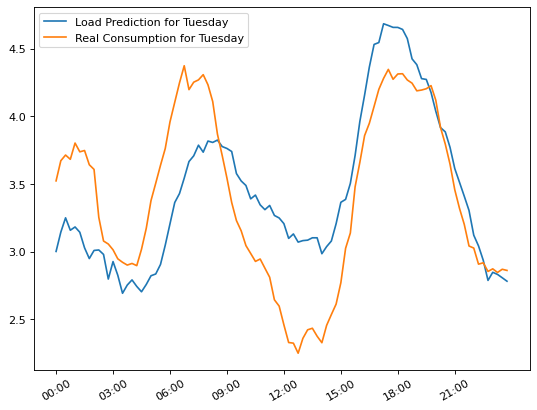

In [41]:
nb_day_test = 112 # To be changed
# print("expected value for charging times=\n", y_test[nb_day_test:nb_day_test+1,:])
# print("obtained value =\n", model.predict(X_test[nb_day_test:nb_day_test+1,:]))
y = model.predict(X_test[nb_day_test:nb_day_test+1,:])
time_str = []
for element in timearray_fullday:
    time_str.append(str(element)[-18:-13])


plt.figure(facecolor='w', figsize=(8, 6), dpi=80)
# plot
plt.plot(time_str,y[0], label='Load Prediction for '+calendar.day_name[int(X_test[nb_day_test:nb_day_test+1,:][0,0])])

plt.plot(time_str,y_test[nb_day_test:nb_day_test+1,:][0], label='Real Consumption for '+calendar.day_name[int(X_test[nb_day_test:nb_day_test+1,:][0,0])])
# beautify the x-labels
# plt.gcf().autofmt_xtime()
plt.xticks(rotation=30)


x_ticks = np.arange(0, 96, 12)
plt.xticks(x_ticks)
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
plt.show()

In [ ]:
# Search for the best value for one parameter in the model(280/698)

S = 0
ii = 0
jj = 0
kk = 0
ll = 0
min = 1000
X_train, X_test, y_train, y_test = train_test_split(Input,Target,test_size=0.4,shuffle=False)

for i in range(19,201,1): 
  for j in range(10,11,1):
    # print(i,j)
    for k in range(10,11,1):
      for l in range(148,149,1):
        model = MLPRegressor(hidden_layer_sizes=(144,10,10,158), activation='relu', solver='adam', 
        alpha=0.0001, batch_size=i, learning_rate_init=0.001, max_iter=200, tol=0.0001, 
        random_state=1, early_stopping=False, validation_fraction=0.1) 
        MSE = []
        model.fit(X_train,y_train)
        Y = model.predict(X_test)
        MSE = pow((Y - y_test),2) # New definition of the score
        S = sum(sum(MSE))/MSE.size
        print(i,j,k,l,S)
        if min > S:
          ii = i
          jj = j
          kk = k
          ll = l
          min = S
# print(min)
print(ii,jj,kk,ll,min)

19 10 10 148 0.23808818333664042
20 10 10 148 0.25120959038174034
21 10 10 148 0.26498566539570534
22 10 10 148 0.24791554311075806
23 10 10 148 0.3153099837137702
24 10 10 148 0.2543718523066459
25 10 10 148 0.3014215865376087
26 10 10 148 0.3365641538643911
27 10 10 148 0.29679704679116153
28 10 10 148 0.29233817959002506
29 10 10 148 0.31711653141040025
30 10 10 148 0.28541892764943105
31 10 10 148 0.27442272971985654
32 10 10 148 0.26675271385499727
33 10 10 148 0.2932076189156322
34 10 10 148 0.28715583362861735
35 10 10 148 0.27806489168899173
36 10 10 148 0.2952854082473727
37 10 10 148 0.26747959185377074
38 10 10 148 0.26560521733802217
39 10 10 148 0.2686578471011569
40 10 10 148 0.26792252397987126
41 10 10 148 0.25136076310679456
42 10 10 148 0.2770427881370892
43 10 10 148 0.24454305682835134
44 10 10 148 0.2751369531315233
45 10 10 148 0.2748782381921379
46 10 10 148 0.29217508185218655
47 10 10 148 0.295042014851806
48 10 10 148 0.2511169187329451
49 10 10 148 0.28608658

In [ ]:
# (114) 0.2555993327474883 0.2659583045938046
# (108 12) 0.24283796204561617 0.2582018378279502
# (128 14 162) 0.21738704161557582 0.23981030705061898
# (140 10 10 160) 0.22042891204112058 0.23393308763630305

93.51170117892624
163.23332510603646
The  average MSE is:  0.1960413022618999
The  average MAE is:  0.34220822873382906
average MAPE of all days:  0.1148387723994171


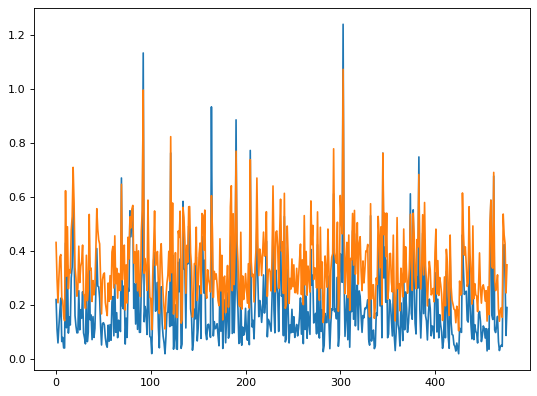

In [ ]:
# Another way to train the model: use few days of data to train and forcast the next day.

range_1 = 20 # Use every two weeks of data to train the model for each time
range_2 = range_1 + 1 # Forcast the next day, so totally 15 days
X = [] # Collect the test arrays
Y = [] # Collect the predict arrays
Y_test = [] # Collect the real arrays
size_2 = int(Input.size/Input[0].size) - range_1

# model = MLPRegressor(hidden_layer_sizes=(176,10,53,47), activation='relu', solver='adam', 
# alpha=0.0001, batch_size=130, learning_rate_init=0.00136, max_iter=200, tol=0.00007, 
# random_state=1, early_stopping=False, validation_fraction=0.1)

model = MLPRegressor(hidden_layer_sizes=(176,10,53,51), activation='relu', solver='adam', 
alpha=0.0001, batch_size=130, learning_rate_init=0.00151, max_iter=200, tol=0.00007, 
random_state=1, early_stopping=False, validation_fraction=0.1) # weekdays

for i in range(size_2):
  X_train, X_test, y_train, y_test = train_test_split(Input[i:i+range_2],Target[i:i+range_2],test_size=1/(range_2),shuffle=False)
  model = model.fit(X_train,y_train)
  y = model.predict(X_test)
  X.append(X_test)
  Y.append(y)
  Y_test.append(y_test)

# Calculate the MSE and MAE for all predicted days

MSE = [] # mean square error
MAE = [] # mean absolute error 
average_MSE = []
average_MAE = []
MAPE = []
average_MAPE = []

for i in range(size_2):
  MSE.append(pow((Y[i] - Y_test[i]),2)) # mean square error
  MAE.append(abs(Y[i] - Y_test[i])) # mean absolute error
  average_MSE.append(sum(sum(MSE[i])) / MSE[i].size)
  average_MAE.append(sum(sum(MAE[i])) / MAE[i].size)
  MAPE.append(abs(Y[i] - Y_test[i])/Y_test[i]) # mean absolute percent error
  average_MAPE.append(sum(sum(MAPE[i])) / MAPE[i].size)

X_MSE = []
X_MAE = []
for i in range(size_2):
  X_MSE.append(i)
  X_MAE.append(i)

plt.figure(facecolor='w', figsize=(8, 6), dpi=80) # frame

# Show the results of all predicted MSEs and MAEs.
plt.plot(X_MSE, average_MSE)
plt.plot(X_MAE, average_MAE)
print(sum(average_MSE))
print(sum(average_MAE))
print("The  average MSE is: ",sum(average_MSE)/size_2)
print("The  average MAE is: ",sum(average_MAE)/size_2)
print("average MAPE of all days: ", sum(average_MAPE)/size_2)

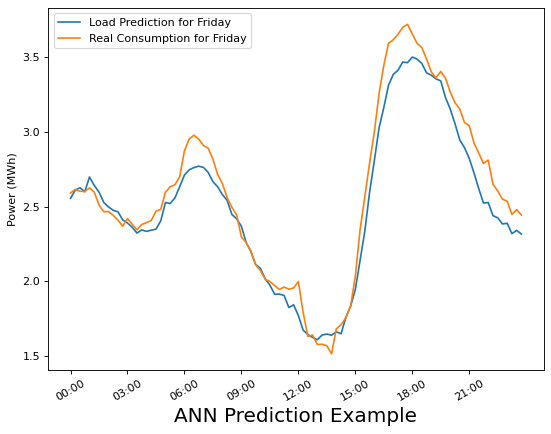

In [ ]:
# Forcasting the power conpusmption of the given day.

number = 102
plt.figure(facecolor='w', figsize=(8, 6), dpi=80) # frame
# plot
plt.plot(time_str,Y[number-1][0], label='Load Prediction for '+calendar.day_name[int(X[number-1][0,0])]) 

plt.plot(time_str,Y_test[number-1][0], label='Real Consumption for '+calendar.day_name[int(X[number-1][0,0])])
# beautify the x-labels
# plt.gcf().autofmt_xtime()
plt.xticks(rotation=30) # Rotate 30 degrees
font1 = {'family' : 'Times New Roman', 'weight' : 'normal', 'size': 10,}
font2 = {'family' : 'Times New Roman', 'weight' : 'normal', 'size': 18,}

plt.xlabel("ANN Prediction Example",font2)         
plt.ylabel(r"Power (MWh)",font1)  
x_ticks = np.arange(0, 96, 12) 
plt.xticks(x_ticks)
ax = plt.gca()
ax.set_facecolor('w') 
plt.legend()
plt.show()

In [ ]:
# # grid search (for the other method: 14+1)
for abc in range(29,30,1):
  ii = 0
  jj = 0
  num_of_tree = []
  i = 0
  min = 1000
  range_1 = abc
  range_2 = range_1+1
  array = []

  size_2 = int(Input.size/Input[0].size) - range_1
  for i in range(9,12,1): # 176
    for j in range(52,55,1): # 47
      S = 0
      model = MLPRegressor(hidden_layer_sizes=(176,i,j,47), activation='relu', solver='adam', 
      alpha=0.0001, batch_size=130, learning_rate_init=0.00136, max_iter=200, tol=0.00007, 
      random_state=1, early_stopping=False, validation_fraction=0.1) 
      for num in range(size_2):
        X_train, X_test, y_train, y_test = train_test_split(Input[num:num+range_2],Target[num:num+range_2],test_size=1/(range_2),shuffle=False)
        MSE = []
        model.fit(X_train,y_train)
        Y = model.predict(X_test)
        MSE = pow((Y - y_test),2) # New definition of the score
        S = S + sum(sum(MSE))/MSE.size
      array.append([i,j,S/size_2])
      print(i,j,S/size_2)
      num_of_tree.append(S/size_2)
      if min > S:
        ii = i
        jj = j
        min = S

  array.append([ii,jj,S/size_2])
  print(ii,jj,min/size_2)  

9 52 0.21993475831145282
9 53 0.2081610557661528
9 54 0.21251324836138882
10 52 0.2113858000673077
10 53 0.20145762780077375
10 54 0.25054920684441917
11 52 0.20896250194261423
11 53 0.24448287523522996
11 54 7.6482705706147645
10 53 0.20145762780077375


In [ ]:
# (176,10,53,51) 0.19774018625056197 156 53 0.1968722047064112


# 2 51 0.217659451600112 28

# (176,10,53,47) [200 0.20145663979286954]

# Final Questions: 

$\color{CornflowerBlue}{\text{Report Guideline: }}$

1.  What can you say on the difference of accuracy if you forecast data at a household level compared to the forecast of data at an aggregated level (a city) ?

# Open questions:
It would also be interesting to study:
1.   the impact of new inputs, such as bank holidays, temperature, ...





